In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import matplotlib as mpl
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import mordred, mordred.descriptors
from mordred import HydrogenBond, Polarizability
from mordred import SLogP, AcidBase, BertzCT, Aromatic, BondCount
from mordred import Calculator
import exmol as exmol
from rdkit.Chem.Draw import rdDepictor
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
rdDepictor.SetPreferCoordGen(True)

IPythonConsole.ipython_useSVG = True
# sns.set_context('notebook')
# sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
#                         'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#F3B562', '#6e5687', '#5C4B51']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
np.random.seed(0)
soldata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv')
features_start_at = list(soldata.columns).index('MolWt')

In [2]:
# make object that can compute descriptors
calc = Calculator()
# calc.register([HydrogenBond.HBondDonor, HydrogenBond.HBondAcceptor])
# calc.register([AcidBase.AcidicGroupCount, AcidBase.BasicGroupCount,
#             Aromatic.AromaticBondsCount])
calc.register([SLogP.SLogP, Polarizability.APol,  BertzCT.BertzCT])
# calc.register([BondCount.BondCount(type='double'),
#             BondCount.BondCount(type='aromatic')])

# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in soldata.SMILES]

raw_features = []
for e, c in zip(molecules, calc.map(molecules, quiet=True)):
    raw_features.append([v for v in c.values()])
    
raw_features

[[3.9581000000000017, 69.89247799999995, 210.377334085253],
 [2.405500000000001, 24.939550999999994, 511.2292477154967],
 [2.1525, 18.005964999999993, 202.66106510209755],
 [8.11610000000001, 115.38730600000001, 1964.648665828827],
 [2.4854000000000003, 67.16178999999998, 769.8999341256456],
 [2.638020000000001, 21.697929999999985, 211.03322454351994],
 [2.6775, 30.306273999999974, 153.9175691117035],
 [0.5283999999999995, 58.55220399999997, 755.7707920367225],
 [3.195800000000001, 28.960343999999985, 452.9607327512057],
 [3.497200000000002, 52.07944599999998, 582.1507932669278],
 [1.5651, 24.26672299999998, 238.24457522403964],
 [2.570800000000001, 32.31268799999998, 301.3575848525983],
 [12.05423999999998, 124.97957999999997, 1804.4185474688127],
 [2.761700000000001, 35.31627399999997, 317.38434399782966],
 [3.7048000000000023, 34.98689499999998, 382.2179844419697],
 [2.6714000000000016, 29.50427399999997, 150.25571236699292],
 [2.5003199999999994, 28.620722999999984, 349.22038935946

In [3]:
raw_features = np.array(raw_features)

In [4]:
# feature_names = soldata.columns[features_start_at:]
# raw_features = soldata[feature_names]
labels = soldata['Solubility']

In [5]:
fm = raw_features.mean()
fs = raw_features.std()
def feature_convert(f):
    f -= fm
    f /= fs
    return f

features = feature_convert(raw_features)

# we have some nans in features, likely because std was 0
features = features.astype(float)
features_select = np.all(np.isfinite(features), axis=0)
features = features[:, features_select]

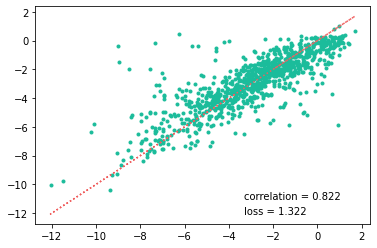

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, shuffle=True)

clf = RandomForestRegressor(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
plt.plot(y_test, predicted, '.')
plt.plot(y_test, y_test, linestyle=':')
plt.text(max(y_test) - 5, min(y_test) + 1, f'correlation = {np.corrcoef(y_test, predicted)[0,1]:.3f}')
plt.text(max(y_test) - 5, min(y_test), f'loss = {np.sqrt(np.mean((y_test - predicted)**2)):.3f}')
plt.savefig('RF-ROC.png')

In [7]:
def model_eval(smiles, _=None):
    molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles]
    # input wrangling. Get some weird values from weird smiles
    # calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
    # raw_features = calc.pandas(molecules, nproc=8, quiet=True)
    features = feature_convert(raw_features)
    features = features.astype(float)
    features = features[:, features_select]
    labels = clf.predict(np.nan_to_num(features))
    return labels
    #return np.random.choice([True, False], size=labels.shape)
labels = model_eval(soldata.SMILES) #.values[:100])

In [8]:
smi = soldata.SMILES[500]
space = exmol.sample_space(smi, model_eval, num_samples=2000)

🤘Done🤘: 100%|██████████| 3471.0/3471 [00:21<00:00, 159.44it/s]              


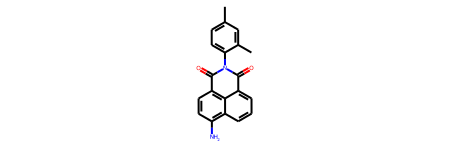

In [9]:
mol = rdkit.Chem.MolFromSmiles(smi)
mol

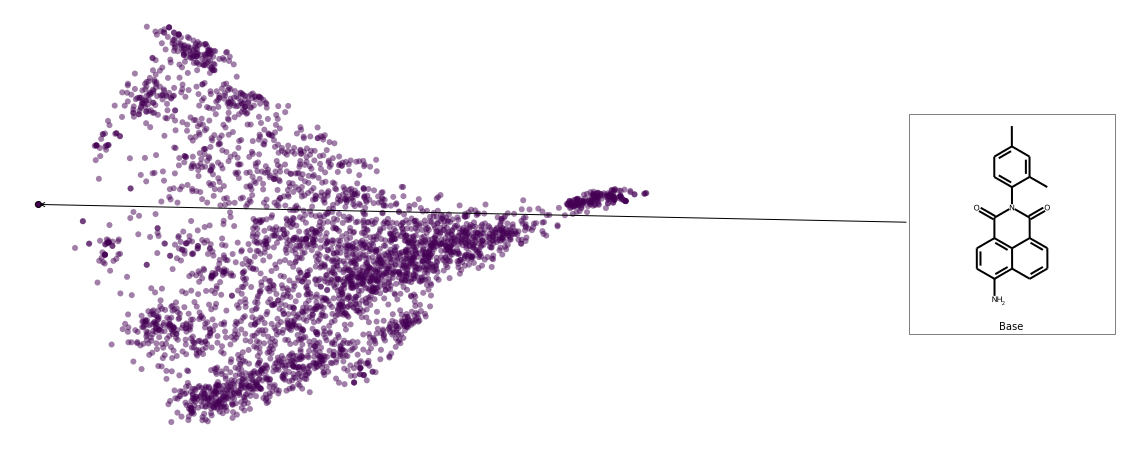

In [10]:
svg = exmol.plot_space(space, [space[0]], mol_size=(200,200), offset=1) #, cartoon=True)
# plt.colorbar(location='left', label='Solubility [Log M]')

## Compare Feature significance to linear regression

In [40]:
def calc_feature_importance(descriptors, tstats):
    from collections import OrderedDict
    feature_importance = {a:b for a, b in zip(descriptors, tstats)}
    feature_importance = dict(sorted(feature_importance.items(),
                 key=lambda item: abs(item[1]),
                 reverse=True))
    #Fitted space important features
    return feature_importance

def linear_model_tstats(x_mat, y, w=None):
    from sklearn.linear_model import LinearRegression
    noisey_x_mat = (x_mat +
                    np.random.uniform(-1e-4, 1e-4,
                                      size=x_mat.shape)) #* w[:, np.newaxis]
    model = LinearRegression(fit_intercept=False).fit(noisey_x_mat, y)
    xtinv = np.linalg.inv(noisey_x_mat.T @ noisey_x_mat)
    beta = model.coef_
    yhat = model.predict(x_mat)
    resids = yhat - y
    SSR = np.sum(resids**2)
    se2_epsilon = SSR / (len(examples) - len(beta))
    se2_beta = se2_epsilon * xtinv
    # now compute t-statistic for existence of coefficients
    tstat = np.sqrt(beta**2 / np.diag(se2_beta))
    lr_importance = calc_feature_importance(descriptors, tstat.flatten())
    return lr_importance

In [24]:
# Linear regression on features
descriptor_type='Classic'
examples = exmol.get_descriptors(space, descriptor_type)
descriptors = list(examples[0].descriptors.descriptor_names)

x_mat = np.array([list(e.descriptors.descriptors)
                  for e in examples]).reshape(len(examples), -1)
# remove zero variance columns
y = np.array([e.yhat for e in examples]).reshape(len(examples), -1).astype(float)

In [41]:
lr_attr = linear_model_tstats(x_mat, y)

{'atomic polarizability': 33.62696657786741,
 'Bertz CT': 26.21140707909802,
 'number of double bonds in non-kekulized structure': 20.122954936269704,
 'number of hydrogen bond acceptor': 9.396736267581606,
 'Wildman-Crippen LogP': 5.401916009496112,
 'acidic group count': 5.387503244777152,
 'number of hydrogen bond donor': 4.179378960160082,
 'basic group count': 0.7196375942684603,
 'number of aromatic bonds in non-kekulized structure': 0.15058989936587314,
 'aromatic bonds count': 0.14928438031868466}

In [46]:
wls_tstats, wls_beta = exmol.lime_explain(space, descriptor_type=descriptor_type)
wls_attr = calc_feature_importance(list(space[0].descriptors.descriptor_names), wls_tstats)

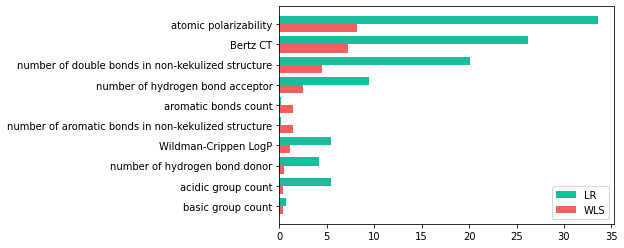

In [48]:
x = (wls_attr.keys())
xaxis = np.arange(len(x))

plt.barh(xaxis-0.2, [lr_attr[i] for i in x], 0.4, label='LR')
plt.barh(xaxis+0.2, [wls_attr[i] for i in x], 0.4, label='WLS')
plt.yticks(xaxis, x)
plt.gca().invert_yaxis()
plt.legend()
plt.savefig('recover_feats.png', bbox_inches='tight', dpi=180)

In [50]:
def get_mi_score(a1, a2):
    from sklearn.metrics import mutual_info_score
    mi = mutual_info_score(a1, a2)
    return mi

lr = []
wls = []
keys = list(lr_importance.keys())
for i in keys:
    lr.append(lr_importance[i])
    wls.append(lr_importance[i])

mi = get_mi_score(lr, wls)

/home/hgandhi/.local/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


In [51]:
mi

2.302585092994046

## Plotting utils

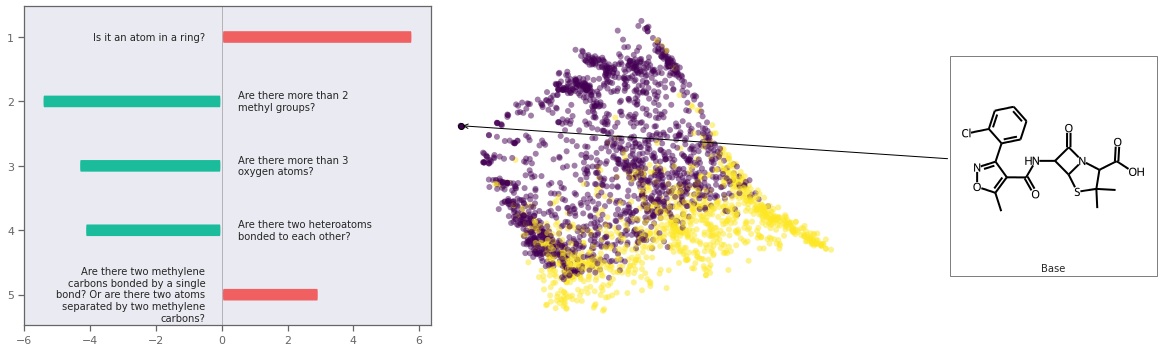

In [13]:
from matplotlib.patches import Rectangle, FancyBboxPatch
import textwrap
fkw = {'figsize': (8,6)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

fig = plt.figure(figsize=(12,5))
# ax_dict = fig.subplot_mosaic('BBBAA')
ax_dict = fig.subplot_mosaic('AAABBB')

r = Rectangle((0, 0), 1, 1)
# cmap = plt.get_cmap("gist_rainbow", 20)
# colors = [mpl.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

t = list(feature_importance.values())[:5]
colors = []
for ti in t:
    if ti < 0:
        colors.append(color_cycle[0])
    if ti > 0:
        colors.append(color_cycle[1])

keys = list(feature_importance.keys())[:5]

bar1 = ax_dict['A'].barh(range(1,6), t, color=colors, height=0.5)
new_patches = []
for patch in reversed(ax_dict['A'].patches):
    bb = patch.get_bbox()
    color=patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.040,rounding_size=0.015",
                        ec="none", fc=color,
                        mutation_aspect=4
                        )
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    ax_dict['A'].add_patch(patch)

count = 1
for rect, ti, k in zip(bar1, t, keys):
    y = rect.get_y() + rect.get_height()/2.
    if len(k) > 60:
        k = textwrap.fill(k, 30)
    elif len(k) > 30:
        k = textwrap.fill(k, 25)
    if ti < 0:
        x = 0.5
        ax_dict['A'].text(x, y, k, ha='left', va='center', wrap=True)
        count+=1
    else:
        x = -0.5
        ax_dict['A'].text(x, y, k, ha='right', va='center', wrap=True)
        count+=1
    
    
ax_dict['A'].axvline(x=0, color='grey', linewidth=0.5)
ax_dict['A'].invert_yaxis()
# ax_dict['A'].get_yaxis().set_ticks([])
exmol.plot_space(space, [space[0]], figure_kwargs=fkw, mol_size=(200,200), offset=1, ax=ax_dict['B'])
# plt.colorbar(location='left', label='Solubility [Log M]')
plt.tight_layout()
plt.savefig('rf-feature.png', dpi=180, bbox_inches='tight')#, dpi=180)

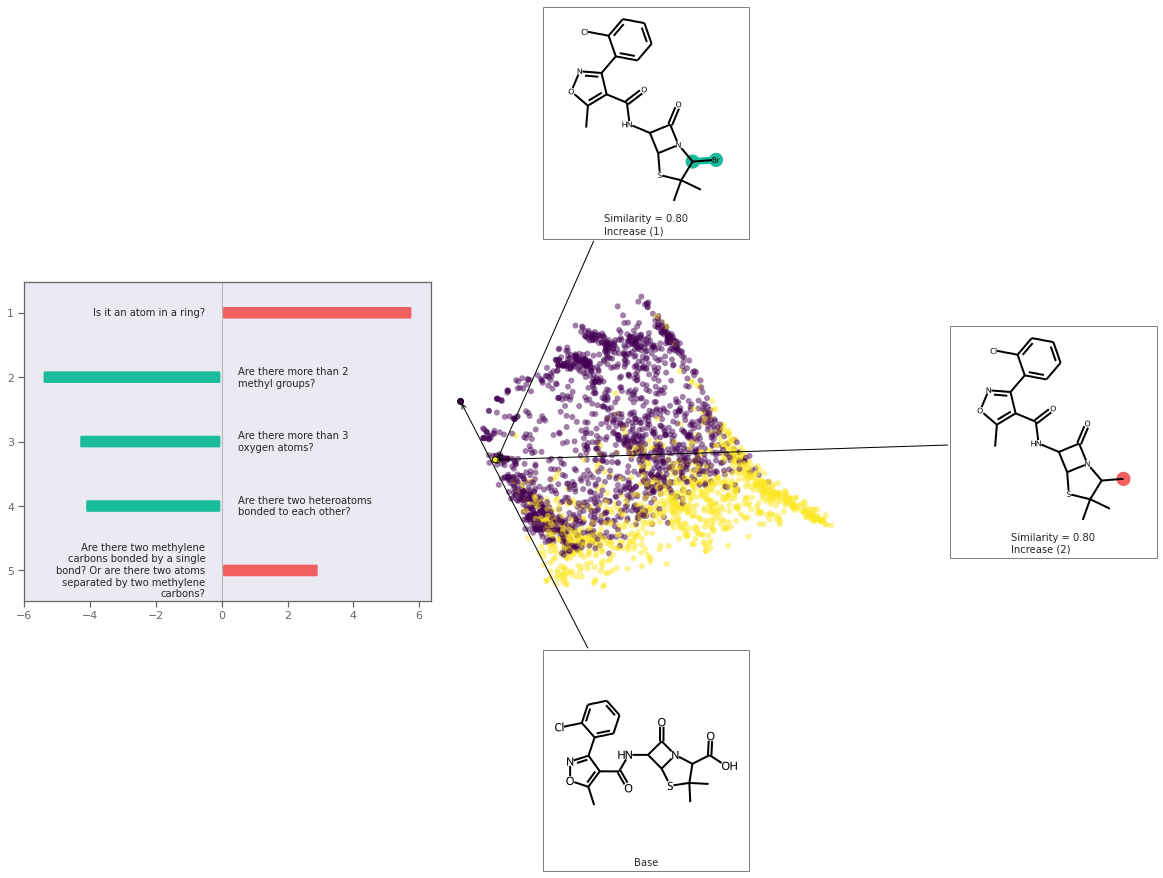

In [18]:
from matplotlib.patches import Rectangle, FancyBboxPatch
import textwrap
fkw = {'figsize': (8,6)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

fig = plt.figure(figsize=(12,5))

ax_dict = fig.subplot_mosaic('AAABBB')

r = Rectangle((0, 0), 1, 1)

t = list(feature_importance.values())[:5]
colors = []
for ti in t:
    if ti < 0:
        colors.append(color_cycle[0])
    if ti > 0:
        colors.append(color_cycle[1])

keys = list(feature_importance.keys())[:5]

bar1 = ax_dict['A'].barh(range(1,6), t, color=colors, height=0.5)
new_patches = []
for patch in reversed(ax_dict['A'].patches):
    bb = patch.get_bbox()
    color=patch.get_facecolor()
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                        abs(bb.width), abs(bb.height),
                        boxstyle="round,pad=-0.040,rounding_size=0.015",
                        ec="none", fc=color,
                        mutation_aspect=4
                        )
    patch.remove()
    new_patches.append(p_bbox)
for patch in new_patches:
    ax_dict['A'].add_patch(patch)

count = 1
for rect, ti, k in zip(bar1, t, keys):
    y = rect.get_y() + rect.get_height()/2.
    if len(k) > 60:
        k = textwrap.fill(k, 30)
    elif len(k) > 30:
        k = textwrap.fill(k, 25)
    if ti < 0:
        x = 0.5
        ax_dict['A'].text(x, y, k, ha='left', va='center', wrap=True)
        count+=1
    else:
        x = -0.5
        ax_dict['A'].text(x, y, k, ha='right', va='center', wrap=True)
        count+=1
    
    
ax_dict['A'].axvline(x=0, color='grey', linewidth=0.5)
ax_dict['A'].invert_yaxis()
exmol.plot_space(space, exps, figure_kwargs=fkw, mol_size=(200,200), offset=1, ax=ax_dict['B'], plot_descriptors = True)
plt.tight_layout()
plt.savefig('rf-feature.png', dpi=180, bbox_inches='tight')#, dpi=180)

In [12]:
t_stats = exmol.lime_explain(exps)
t_stats

array([0.04069388, 0.20687185, 0.27214578, 0.14697905, 0.32228409,
       0.02708995, 0.18915174, 0.06257426, 0.09786646, 0.3222839 ])

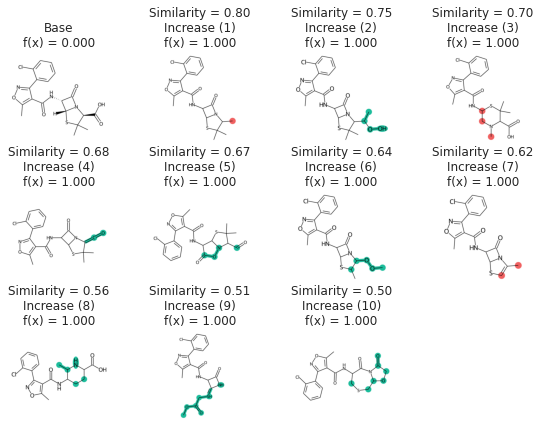

In [13]:
fkw = {'figsize': (8,6)}
mpl.rc('axes', titlesize=12)
exmol.plot_cf(exps, figure_kwargs=fkw, mol_size=(450,400), nrows=3)
plt.savefig('rf-simple.png', dpi=180)

## Schematic Plots

In [11]:
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit.Chem.Draw import MolToImage as mol2img
dos = rdkit.Chem.Draw.MolDrawOptions()
dos.useBWAtomPalette()
#dos.minFontSize = fontsize
img = mol2img(smi2mol(exps[0].smiles), options=dos)
img.save('rf-schem-1.png')

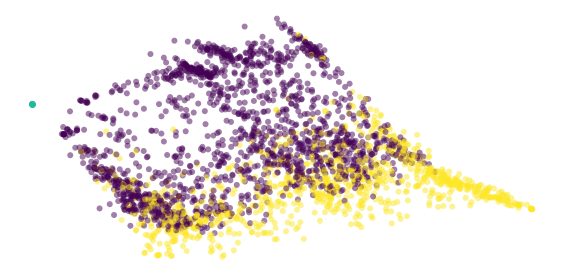

In [12]:
fkw = {'figsize': (8,4)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
exmol.plot_space(space, [], figure_kwargs=fkw, mol_size=(300,200), offset=1)
plt.scatter(exps[0].position[0], exps[0].position[1])
plt.tight_layout()
plt.savefig('rf-schem-2.png', bbox_inches='tight', dpi=180)

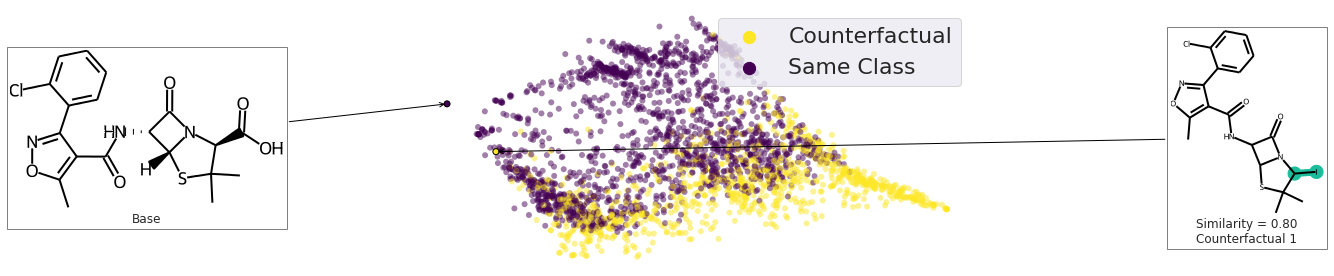

In [13]:
fkw = {'figsize': (8,4)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
exmol.plot_space(space, exps[:2], figure_kwargs=fkw, mol_size=(300,200), offset=0)
plt.scatter([], [], label='Counterfactual', s=150, color=plt.get_cmap('viridis')(1.0))
plt.scatter([], [], label='Same Class', s=150, color=plt.get_cmap('viridis')(0.0))
plt.legend(fontsize=22)
plt.tight_layout()
plt.savefig('rf-schem-3.png', bbox_inches='tight', dpi=180)

## Chemed

In [14]:
cspace = exmol.sample_space('Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C', model_eval)
zspace = exmol.sample_space('Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C', model_eval, num_samples=500, preset='chemed')

🤘Done🤘: 100%|██████████| 2767.0/2767 [00:25<00:00, 107.12it/s]                  
🤘Done🤘: 100%|██████████| 147.0/147 [00:00<00:00, 856.80it/s]                    


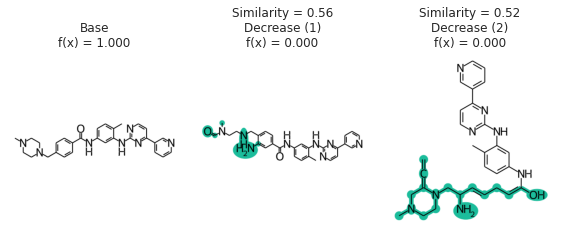

In [15]:
fkw = {'figsize': (8,6)}
mpl.rc('axes', titlesize=12)
exmol.plot_cf(exmol.rcf_explain(cspace, nmols=4), figure_kwargs=fkw, mol_fontsize=26, mol_size=(400,400), nrows=1)
plt.savefig('gleevac-cs.png', bbox_inches='tight', dpi=180)

[Example(smiles='Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C', selfies='[C][C][=C][C][=C][Branch2_1][Ring1][Branch2_1][C][=C][Ring1][Branch1_2][N][C][=N][C][=C][C][Branch1_2][Ring2][=N][Ring1][Branch1_2][C][=C][C][=C][N][=C][Ring1][Branch1_2][N][C][Branch1_2][C][=O][C][=C][C][=C][Branch1_1][Branch1_1][C][=C][Ring1][Branch1_2][C][N][C][C][N][Branch1_1][Branch1_1][C][C][Ring1][Branch1_2][C]', similarity=1.0, yhat=1, index=0, position=array([-1.18271771,  0.9320159 ]), is_origin=True, cluster=-1, label=None), Example(smiles='CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN(CCO)C(=O)CN(C)C)NC3=NC=CC(=N3)C4=CN=CC=C4', selfies='[C][C][=C][Branch2_1][Ring2][Branch2_2][C][=C][Branch1_1][Branch1_1][C][=C][Ring1][Branch1_2][N][C][Branch1_2][C][=O][C][=C][C][=C][Branch1_1][Branch1_1][C][=C][Ring1][Branch1_2][C][N][Branch1_1][Ring2][C][C][O][C][Branch1_2][C][=O][C][N][Branch1_1][C][C][C][N][C][=N][C][=C][C][Branch1_2][Ring2][=N][Ring1][Branch1_2][C][=C][N][=C][C][=C][Ring1][Branch1_2]', similar

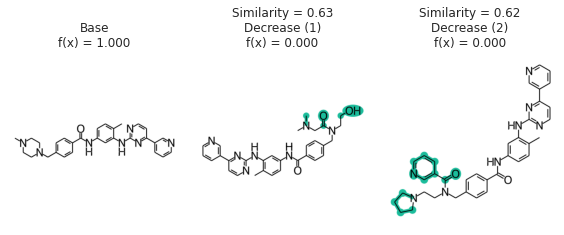

In [17]:
exps = exmol.rcf_explain(zspace, nmols=5)
# fix ionization
fkw = {'figsize': (8,6)}
mpl.rc('axes', titlesize=12)
print(exps, len(exps))
exmol.plot_cf(exps, figure_kwargs=fkw, mol_fontsize=26, mol_size=(400,400), nrows=1)
plt.savefig('gleevac-c.png', bbox_inches='tight', dpi=180)

# Effect of backtrack

In [110]:
spaces = []
backtracks = [0.0, 0.1, 0.5, 1.0]
for bi in backtracks:
    spaces.append(exmol.sample_space(example_neg, model_eval, preset='zinc', method_kwargs={'backtrack_prob': bi}))

NameError: name 'example_neg' is not defined

In [ ]:
counts = [len(s) for s in spaces]
sim = [np.mean([e.similarity for e in s]) for s in spaces]

In [ ]:
plt.figure()
plt.bar(np.arange(len(counts)), counts,  align='center')
# set labels
plt.xticks(np.arange(2 * len(counts)),  2* backtracks)
plt.ylabel('Unique ZINC Structures')
plt.xlabel('Backtrack Probability')
plt.axvline(x=len(counts) - 0.5, color='#333', linewidth=1)
ax2 = plt.twinx()
ax2.bar(np.arange(len(counts), 2 * len(counts)), sim, color='C3', align='center')
# set labels
ax2.set_ylabel('Tanimoto Similarity')

plt.savefig('zinc-bt.pdf')